In [1]:
# see the internal structure of label file
from scipy.io import loadmat

# Load one .mat file to inspect structure
data = loadmat('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/testdata.mat')

# See available keys (ignore '__header__', '__globals__', '__version__')
print(data.keys())

# Peek into the first entry to check structure
print(data['testdata'][0][0])  # Adjust if needed depending on structure


dict_keys(['__header__', '__version__', '__globals__', 'testdata'])
(array(['test/1002_1.png'], dtype='<U15'), array(['PRIVATE'], dtype='<U7'), array([[array(['PRIVATE'], dtype='<U7'), array(['136'], dtype='<U3'),
        array(['17'], dtype='<U2'), array(['3SIDED'], dtype='<U6'),
        array(['55496002'], dtype='<U8'), array(['97'], dtype='<U2'),
        array(['ARCHANA'], dtype='<U7'), array(['AXELROD'], dtype='<U7'),
        array(['BANKS'], dtype='<U5'), array(['BLOOMERS'], dtype='<U8'),
        array(['BROOK'], dtype='<U5'), array(['CATHEDRAL'], dtype='<U9'),
        array(['CHANDIGARH'], dtype='<U10'),
        array(['CODE'], dtype='<U4'), array(['COLD'], dtype='<U4'),
        array(['DIVIDE'], dtype='<U6'), array(['ENOUGH'], dtype='<U6'),
        array(['EXTRA'], dtype='<U5'), array(['FARM'], dtype='<U4'),
        array(['FRIENDS'], dtype='<U7'), array(['FULLER'], dtype='<U6'),
        array(['GREAT'], dtype='<U5'), array(['HANTECH'], dtype='<U7'),
        array(['IRON'], dtyp

In [2]:
# print the image filenames and labels
from scipy.io import loadmat

# Load the .mat file
mat_path = '/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/testdata.mat'
data = loadmat(mat_path)

# Extract the structured array
testdata = data['testdata'][0]  # it's a 1D array of structs

# Extract image-label pairs
image_label_pairs = []
for entry in testdata:
    img_name = str(entry['ImgName'][0])
    label = str(entry['GroundTruth'][0])
    image_label_pairs.append((img_name, label))

# Show a few
for i in range(5):
    print(image_label_pairs[i])


('test/1002_1.png', 'PRIVATE')
('test/1002_2.png', 'PARKING')
('test/1009_1.png', 'SALUTES')
('test/100_1.png', 'DOLCE')
('test/100_2.png', 'GABBANA')


In [15]:
# llava answer accuracy in OCR in iiit5k, assuming the answer file has filename format as original dataset
import pandas as pd
from scipy.io import loadmat

# === Load .mat files ===
mat_dir = '/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K'
testdata = loadmat(f'{mat_dir}/testdata.mat')['testdata'][0]
traindata = loadmat(f'{mat_dir}/traindata.mat')['traindata'][0]

# === Build ground truth mapping: { "test/1002_1.png": "PRIVATE" } ===
gt_labels = {}
for entry in list(testdata) + list(traindata):
    img_name = str(entry['ImgName'][0])
    label = str(entry['GroundTruth'][0])
    gt_labels[img_name.lower()] = label.lower()  # case-insensitive match

# === Load VLM results ===
csv_path = '/proj/berzelius-2024-90/users/x_liumi/DL_proj/models/LLaVA/data/txt_db/iiit5k_cpm/results.csv'
df = pd.read_csv(csv_path, header=None, names=["img_path", "answer"])

# Extract last two folders from the image path to get a key like "test/1002_1.png"
df['img_key'] = df['img_path'].apply(lambda p: '/'.join(p.split('/')[-2:]).lower())

# === Match each image's ground truth with LLaVA answer ===
def is_hit(row):
    label = gt_labels.get(row['img_key'])
    if label is None:
        return False
    return label in row['answer'].lower()

df['hit'] = df.apply(is_hit, axis=1)

# === Accuracy calculation ===
accuracy = df['hit'].mean()
print(f"MiniCPM OCR accuracy: {accuracy:.2%}")


MiniCPM OCR accuracy: 95.22%


In [5]:
# split out finetune/evaluate images
import os
import shutil
import re

# base paths
base = '/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K'
test_dir = os.path.join(base, 'test')

# new folders
splits = {
    '2000': ('unlabeled_2000', 2000, 'evaluate_1000', 1000),
    '2500': ('unlabeled_2500', 2500,  'evaluate_500', 500),
}

# make sure sorted by filename
# fnames = sorted([f for f in os.listdir(test_dir) if f.lower().endswith('.png')])
def natural_key(filename):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', filename)]

fnames = sorted([f for f in os.listdir(test_dir) if f.lower().endswith('.png')],
                key=natural_key)

for key, (u_folder, u_count, e_folder, e_count) in splits.items():
    u_path = os.path.join(base, u_folder)
    e_path = os.path.join(base, e_folder)
    os.makedirs(u_path, exist_ok=True)
    os.makedirs(e_path, exist_ok=True)

    # slice out the first/last
    first = fnames[:u_count]
    last  = fnames[-e_count:]

    # copy
    for f in first:
        shutil.copy(os.path.join(test_dir, f), os.path.join(u_path, f))
    for f in last:
        shutil.copy(os.path.join(test_dir, f), os.path.join(e_path, f))

print("Done splitting test/ into unlabeled_2000, evaluate_1000, unlabeled_2500, evaluate_500.")


Done splitting test/ into unlabeled_2000, evaluate_1000, unlabeled_2500, evaluate_500.


In [ ]:
# prepare the json files for LLaVA fine tuning (REVISED BELOW)
import os
import re
import uuid
import json
from scipy.io import loadmat
import pandas as pd

# --- helper for natural sort ---
def natural_key(filename):
    return [
        int(text) if text.isdigit() else text.lower()
        for text in re.split(r'(\d+)', filename)
    ]

# --- paths ---
base       = '/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K'
train_mat  = os.path.join(base, 'traindata.mat')
csv_path   = '/proj/berzelius-2024-90/users/x_liumi/DL_proj/models/LLaVA/data/txt_db/iiit5k_cpm/results.csv'
test_dir   = os.path.join(base, 'test')

# --- load train ground‐truth (map by basename!) ---
traindata = loadmat(train_mat)['traindata'][0]
train_map = {
    os.path.basename(entry['ImgName'][0]): entry['GroundTruth'][0]
    for entry in traindata
}

# --- load pseudo CSV (also map by basename) ---
df = pd.read_csv(csv_path)
df['base'] = df['filename'].apply(lambda p: os.path.basename(p))
pseudo_map = dict(zip(df['base'], df['answer']))

# --- sorted test filenames (only basename) ---
test_fnames = sorted(
    [f for f in os.listdir(test_dir) if f.lower().endswith('.png')],
    key=natural_key
)
unlabeled_2000 = test_fnames[:2000]
unlabeled_2500 = test_fnames[:2500]

# --- sample builder (expects basename keys in label_map) ---
def make_samples(basenames, label_map, prefix):
    samples = []
    for base in basenames:
        lab = label_map.get(base)
        if lab is None:
            print(f"⚠️ no label for {base} under prefix {prefix}")
            continue
        samples.append({
            "id": str(uuid.uuid4()),
            "image": f"{prefix}/{base}",
            "conversations": [
                {"from": "human", "value": "<image>\nWhat are the words in the image?"},
                {"from": "gpt",   "value": f"The words in the image are \"{lab}\""}
            ]
        })
    return samples

# --- build lists of basenames for train + psuedo ---
train_bases   = sorted(train_map.keys(), key=natural_key)
train_samples = make_samples(train_bases, train_map,    'train')
psudo_2000    = make_samples(unlabeled_2000,    pseudo_map, 'unlabeled_2000')
psudo_2500    = make_samples(unlabeled_2500,    pseudo_map, 'unlabeled_2500')

# --- combine and dump ---
to_dump = {
    'llava_iiit5k_train.json':          train_samples,
    'llava_iiit5k_train2000psudo.json': train_samples + psudo_2000,
    'llava_iiit5k_train2500psudo.json': train_samples + psudo_2500,
}

for fname, data in to_dump.items():
    out = os.path.join(base, fname)
    with open(out, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Wrote {len(data)} samples → {out}")



Wrote 2000 samples → /proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/llava_iiit5k_train.json
Wrote 4000 samples → /proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/llava_iiit5k_train2000psudo.json
Wrote 4500 samples → /proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/llava_iiit5k_train2500psudo.json


In [1]:
from __future__ import annotations
import os, re, uuid, json, pandas as pd
from pathlib import Path
from scipy.io import loadmat

# --------------------------------------------------------------------
# paths – change here if your layout differs
BASE     = Path('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K')
CPM_CSV  = Path('/proj/berzelius-2024-90/users/x_liumi/DL_proj/models/LLaVA/data/txt_db/iiit5k_cpm/results.csv')
TRAIN_MAT = BASE / 'traindata.mat'
TEST_DIR  = BASE / 'test'
# --------------------------------------------------------------------

# natural sort helper (unchanged)
def natural_key(fn: str):
    return [int(x) if x.isdigit() else x.lower()
            for x in re.split(r'(\d+)', fn)]

# ---------- 1.  clean & filter CPM pseudo labels -------------------
ALNUM_RE = re.compile(r'[A-Za-z0-9]+')

def clean_cpm(raw: str | None) -> str | None:
    """
    Strip punctuation/quotes, split into alphanumeric tokens,
    then always return the last token (uppercased), or None if no tokens.
    """
    if not isinstance(raw, str):
        return None

    # find all A–Z, a–z, 0–9 substrings
    tokens = ALNUM_RE.findall(raw)    # e.g. ["The","text","in","the","image","is","24"]
    if not tokens:
        return None

    # Always pick the very last token, whatever its length
    return tokens[-1].upper()         # e.g. "24" or "A" or "BANKNORTH"

# ---------- 2.  load official train labels -------------------------
traindata = loadmat(TRAIN_MAT)['traindata'][0]
train_map = {Path(e['ImgName'][0]).name: e['GroundTruth'][0].upper()
             for e in traindata}

# ---------- 3.  load & clean CPM CSV -------------------------------
cpm_df = pd.read_csv(CPM_CSV, names=['filename', 'answer'], header=0)
cpm_df['base']  = cpm_df['filename'].apply(lambda p: Path(p).name)
cpm_df['clean'] = cpm_df['answer'].apply(clean_cpm)
pseudo_map = {b: c for b, c in zip(cpm_df['base'], cpm_df['clean']) if c}

print(f"[INFO] kept {len(pseudo_map):,} / {len(cpm_df):,} CPM rows after filtering")

# ---------- 4.  determine test-set slices --------------------------
test_names = sorted([f for f in os.listdir(TEST_DIR) if f.endswith('.png')],
                    key=natural_key)
UNLABELED_2000 = test_names[:2000]
UNLABELED_2500 = test_names[:2500]

# ---------- 5.  helper to build a JSON sample list -----------------
def make_samples(basenames, label_map, prefix):
    out = []
    for base in basenames:
        lab = label_map.get(base)
        if not lab:
            continue
        out.append({
            "id": str(uuid.uuid4()),
            "image": f"{prefix}/{base}",
            "conversations": [
                {"from": "human",
                 "value": "<image>\nWhat are the words in the image?"},
                {"from": "gpt",
                 "value": f'The words in the image are "{lab}"'}
            ]
        })
    return out

# ---------- 6.  build three splits ---------------------------------
train_samples   = make_samples(sorted(train_map),      train_map,   'train')
pseudo_2000     = make_samples(UNLABELED_2000, pseudo_map, 'unlabeled_2000')
pseudo_2500     = make_samples(UNLABELED_2500, pseudo_map, 'unlabeled_2500')

OUTPUTS = {
    BASE / 'llava_iiit5k_train.json':                train_samples,
    BASE / 'llava_iiit5k_train2000psudo.json': train_samples + pseudo_2000,
    BASE / 'llava_iiit5k_train2500psudo.json': train_samples + pseudo_2500,
}

for path, data in OUTPUTS.items():
    with open(path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"[WRITE] {len(data):,} samples  →  {path}")


[INFO] kept 4,999 / 5,000 CPM rows after filtering
[WRITE] 2,000 samples  →  /proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/llava_iiit5k_train.json
[WRITE] 3,999 samples  →  /proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/llava_iiit5k_train2000psudo.json
[WRITE] 4,499 samples  →  /proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/llava_iiit5k_train2500psudo.json


In [5]:
from __future__ import annotations
import os, re, uuid, json, pandas as pd
from pathlib import Path
from scipy.io import loadmat

# --------------------------------------------------------------------
# paths – change here if your layout differs
BASE     = Path('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K')
CPM_CSV  = Path('/proj/berzelius-2024-90/users/x_liumi/DL_proj/models/LLaVA/data/txt_db/iiit5k_cpm/results.csv')
TRAIN_MAT = BASE / 'traindata.mat'
TEST_DIR  = BASE / 'test'
# --------------------------------------------------------------------

# natural sort helper (unchanged)
def natural_key(fn: str):
    return [int(x) if x.isdigit() else x.lower()
            for x in re.split(r'(\d+)', fn)]

# ---------- 1.  clean & filter CPM pseudo labels -------------------
ALNUM_RE = re.compile(r'[A-Za-z0-9]+')

def clean_cpm(raw: str | None) -> str | None:
    """
    Strip punctuation/quotes, split into alphanumeric tokens,
    then always return the last token (uppercased), or None if no tokens.
    """
    if not isinstance(raw, str):
        return None
    tokens = ALNUM_RE.findall(raw)
    if not tokens:
        return None
    return tokens[-1].upper()

# ---------- 2.  load official train labels -------------------------
traindata = loadmat(TRAIN_MAT)['traindata'][0]
train_map = {Path(e['ImgName'][0]).name: e['GroundTruth'][0].upper()
             for e in traindata}

# ---------- 3.  load & clean CPM CSV -------------------------------
cpm_df = pd.read_csv(CPM_CSV, names=['filename', 'answer'], header=0)
cpm_df['base']  = cpm_df['filename'].apply(lambda p: Path(p).name)
cpm_df['clean'] = cpm_df['answer'].apply(clean_cpm)
pseudo_map = {b: c for b, c in zip(cpm_df['base'], cpm_df['clean']) if c}

print(f"[INFO] kept {len(pseudo_map):,} / {len(cpm_df):,} CPM rows after filtering")

# ---------- 4.  determine test-set slices --------------------------
test_names = sorted([f for f in os.listdir(TEST_DIR) if f.endswith('.png')],
                    key=natural_key)

UNLABELED_200  = test_names[:200]
UNLABELED_500  = test_names[:500]
UNLABELED_1000 = test_names[:1000]

# ---------- 5.  helper to build a JSON sample list -----------------
def make_samples(basenames, label_map, prefix):
    out = []
    for base in basenames:
        lab = label_map.get(base)
        if not lab:
            continue
        out.append({
            "id": str(uuid.uuid4()),
            "image": f"{prefix}/{base}",
            "conversations": [
                {"from": "human",
                 "value": "<image>\nWhat are the words in the image?"},
                {"from": "gpt",
                 "value": f'The words in the image are "{lab}"'}
            ]
        })
    return out

# ---------- 6.  build three pseudo‐augmented splits ---------------
train_samples   = make_samples(sorted(train_map), train_map,   'train')
pseudo_200      = make_samples(UNLABELED_200,   pseudo_map, 'unlabeled_2000')
pseudo_500      = make_samples(UNLABELED_500,   pseudo_map, 'unlabeled_2000')
pseudo_1000     = make_samples(UNLABELED_1000,  pseudo_map, 'unlabeled_2000')

OUTPUTS = {
    BASE / 'llava_iiit5k_train200psudo.json':  train_samples + pseudo_200,
    BASE / 'llava_iiit5k_train500psudo.json':  train_samples + pseudo_500,
    BASE / 'llava_iiit5k_train1000psudo.json': train_samples + pseudo_1000,
}

for path, data in OUTPUTS.items():
    with open(path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"[WRITE] {len(data):,} samples  →  {path}")


[INFO] kept 4,999 / 5,000 CPM rows after filtering
[WRITE] 2,199 samples  →  /proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/llava_iiit5k_train200psudo.json
[WRITE] 2,499 samples  →  /proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/llava_iiit5k_train500psudo.json
[WRITE] 2,999 samples  →  /proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K/llava_iiit5k_train1000psudo.json


In [5]:
import os
import pandas as pd
from scipy.io import loadmat

# === Load .mat files ===
mat_dir  = '/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K'
testdata = loadmat(f'{mat_dir}/testdata.mat')['testdata'][0]

# === Build ground truth mapping ===
gt_labels = {
    entry['ImgName'][0].lower(): entry['GroundTruth'][0].lower()
    for entry in testdata
}

# === Load LLaVA results CSV ===
csv_path = '/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_pretrained_1000/question_1/results.csv'
df = pd.read_csv(csv_path, names=["img_path", "answer"], header=0)

# === Normalize and sanitize answers ===
df['img_key'] = df['img_path'].apply(
    lambda p: f"test/{os.path.basename(p)}".lower()
)
df['answer'] = df['answer'].fillna('').astype(str)

# === Compare to ground truth ===
def is_hit(row):
    true_txt = gt_labels.get(row['img_key'], '')
    return true_txt in row['answer'].lower()

df['hit'] = df.apply(is_hit, axis=1)

# === Report accuracy ===
acc = df['hit'].mean()
hits = int(df['hit'].sum())
total = len(df)
print(f"LLaVA OCR accuracy on evaluate_1000: {acc:.2%} ({hits}/{total})")


LLaVA OCR accuracy on evaluate_1000: 36.30% (363/1000)


In [ ]:
# small wrapper for evaluation splits accuracy
import os
import pandas as pd
from scipy.io import loadmat

# --- load ground truth once ---
mat_dir  = '/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K'
testdata = loadmat(f'{mat_dir}/testdata.mat')['testdata'][0]
gt_labels = {
    entry['ImgName'][0].lower(): entry['GroundTruth'][0].lower()
    for entry in testdata
}

def evaluate(csv_path, tag):
    df = pd.read_csv(csv_path, names=["img_path", "answer"], header=0)
    df['img_key'] = df['img_path'].apply(
        lambda p: f"test/{os.path.basename(p)}".lower()
    )
    # fill any NaN and cast to str
    df['answer'] = df['answer'].fillna('').astype(str)
    
    df['hit'] = df.apply(
        lambda row: gt_labels.get(row['img_key'], '') in row['answer'].lower(),
        axis=1
    )
    acc = df['hit'].mean()
    hits, total = int(df['hit'].sum()), len(df)
    print(f"{tag:>12}: {acc:.2%} ({hits}/{total})")

# list of (csv, label) pairs
to_eval = [
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_pretrained_500/question_1/results.csv',
     'evaluate_500_pretrained'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_pretrained_1000/question_1/results.csv',
     'evaluate_1000_pretrained'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain_500/question_1/results.csv',
     'evaluate_500_loratrain'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain_1000/question_1/results.csv',
     'evaluate_1000_loratrain'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain2000psudo_500/question_1/results.csv',
     'evaluate_500_loratrain2000psudo'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain2000psudo_1000/question_1/results.csv',
     'evaluate_1000_loratrain2000psudo'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain2500psudo_500/question_1/results.csv',
     'evaluate_500_loratrain2500psudo'),
]

for path, tag in to_eval:
    evaluate(path, tag)


evaluate_500_pretrained: 30.40% (152/500)
evaluate_1000_pretrained: 36.30% (363/1000)
evaluate_500_loratrain: 31.20% (156/500)
evaluate_1000_loratrain: 36.80% (368/1000)
evaluate_500_loratrain2000psudo: 28.00% (140/500)
evaluate_1000_loratrain2000psudo: 33.70% (337/1000)
evaluate_500_loratrain2500psudo: 33.00% (165/500)


In [14]:
import os
import pandas as pd
from scipy.io import loadmat

# --- load ground truth once ---
mat_dir  = '/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/IIIT5K'
testdata = loadmat(f'{mat_dir}/testdata.mat')['testdata'][0]
gt_labels = {
    entry['ImgName'][0].lower(): entry['GroundTruth'][0].lower()
    for entry in testdata
}

def evaluate(csv_path, tag):
    df = pd.read_csv(csv_path, names=["img_path", "answer"], header=0)
    df['img_key'] = df['img_path'].apply(
        lambda p: f"test/{os.path.basename(p)}".lower()
    )
    # fill any NaN and cast to str
    df['answer'] = df['answer'].fillna('').astype(str)
    
    df['hit'] = df.apply(
        lambda row: gt_labels.get(row['img_key'], '') in row['answer'].lower(),
        axis=1
    )
    acc = df['hit'].mean()
    hits, total = int(df['hit'].sum()), len(df)
    print(f"{tag:>12}: {acc:.2%} ({hits}/{total})")

# list of (csv, label) pairs
to_eval = [
    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_pretrained_500_t6p9b1/question_1/results.csv',
    #  'evaluate_500_pretrained_t6p9b1'),
    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_pretrained_1000_t6p9b1/question_1/results.csv',
    #  'evaluate_1000_pretrained_t6p9b1'),
    
    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_pretrained_500_t1p1b2/question_1/results.csv',
    #  'evaluate_500_pretrained_t1p1b2'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_pretrained_1000_t1p1b2/question_1/results.csv',
     'evaluate_1000_pretrained_t1p1b2'),

    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain_500_ori_t6p9b1/question_1/results.csv',
    #  'evaluate_500_loratrain_ori_t6p9b1'),
    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain_1000_ori_t6p9b1/question_1/results.csv',
    #  'evaluate_1000_loratrain_ori_t6p9b1'),
    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain_500_ori_t1p1b2/question_1/results.csv',
    #  'evaluate_500_loratrain_ori_t1p1b2'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain_1000_ori_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain_ori_t1p1b2'),

    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain_1000_new_t6p9b1/question_1/results.csv',
    #  'evaluate_1000_loratrain_new_t6p9b1'),
    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain_1000_new_t1p1b2/question_1/results.csv',
    #  'evaluate_1000_loratrain_new_t1p1b2'),

    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain200psudo_1000_ori_t6p9b1/question_1/results.csv',
    #  'evaluate_1000_loratrain200psudo_ori_t6p9b1'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain200psudo_1000_ori_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain200psudo_ori_t1p1b2'),

    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain500psudo_1000_ori_t6p9b1/question_1/results.csv',
    #  'evaluate_1000_loratrain500psudo_ori_t6p9b1'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain500psudo_1000_ori_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain500psudo_ori_t1p1b2'),

    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain1000psudo_1000_ori_t6p9b1/question_1/results.csv',
    #  'evaluate_1000_loratrain1000psudo_ori_t6p9b1'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain1000psudo_1000_ori_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain1000psudo_ori_t1p1b2'),

    # ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain2000psudo_1000_ori_t6p9b1/question_1/results.csv',
    #  'evaluate_1000_loratrain2000psudo_ori_t6p9b1'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain2000psudo_1000_ori_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain2000psudo_ori_t1p1b2'),

    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain200psudo_1000_ori_hybrid2to1_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain200psudo_ori_hybrid2to1_t1p1b2'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain500psudo_1000_ori_hybrid2to1_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain500psudo_ori_hybrid2to1_t1p1b2'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain1000psudo_1000_ori_hybrid2to1_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain1000psudo_ori_hybrid2to1_t1p1b2'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain2000psudo_1000_ori_hybrid2to1_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain2000psudo_ori_hybrid2to1_t1p1b2'),
    
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain200psudo_1000_ori_hybrid1to2_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain200psudo_ori_hybrid1to2_t1p1b2'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain500psudo_1000_ori_hybrid1to2_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain500psudo_ori_hybrid1to2_t1p1b2'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain1000psudo_1000_ori_hybrid1to2_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain1000psudo_ori_hybrid1to2_t1p1b2'),
    ('/proj/berzelius-2024-90/users/x_liumi/DL_proj/data/txt_db/iiit5k_llava_loratrain2000psudo_1000_ori_hybrid1to2_t1p1b2/question_1/results.csv',
     'evaluate_1000_loratrain2000psudo_ori_hybrid1to2_t1p1b2'),
]

for path, tag in to_eval:
    evaluate(path, tag)


evaluate_1000_pretrained_t1p1b2: 37.60% (376/1000)
evaluate_1000_loratrain_ori_t1p1b2: 39.00% (390/1000)
evaluate_1000_loratrain200psudo_ori_t1p1b2: 39.10% (391/1000)
evaluate_1000_loratrain500psudo_ori_t1p1b2: 38.70% (387/1000)
evaluate_1000_loratrain1000psudo_ori_t1p1b2: 37.60% (376/1000)
evaluate_1000_loratrain2000psudo_ori_t1p1b2: 38.90% (389/1000)
evaluate_1000_loratrain200psudo_ori_hybrid2to1_t1p1b2: 34.80% (348/1000)
evaluate_1000_loratrain500psudo_ori_hybrid2to1_t1p1b2: 33.90% (339/1000)
evaluate_1000_loratrain1000psudo_ori_hybrid2to1_t1p1b2: 34.80% (348/1000)
evaluate_1000_loratrain2000psudo_ori_hybrid2to1_t1p1b2: 37.10% (371/1000)
evaluate_1000_loratrain200psudo_ori_hybrid1to2_t1p1b2: 37.20% (372/1000)
evaluate_1000_loratrain500psudo_ori_hybrid1to2_t1p1b2: 35.70% (357/1000)
evaluate_1000_loratrain1000psudo_ori_hybrid1to2_t1p1b2: 32.00% (320/1000)
evaluate_1000_loratrain2000psudo_ori_hybrid1to2_t1p1b2: 36.60% (366/1000)


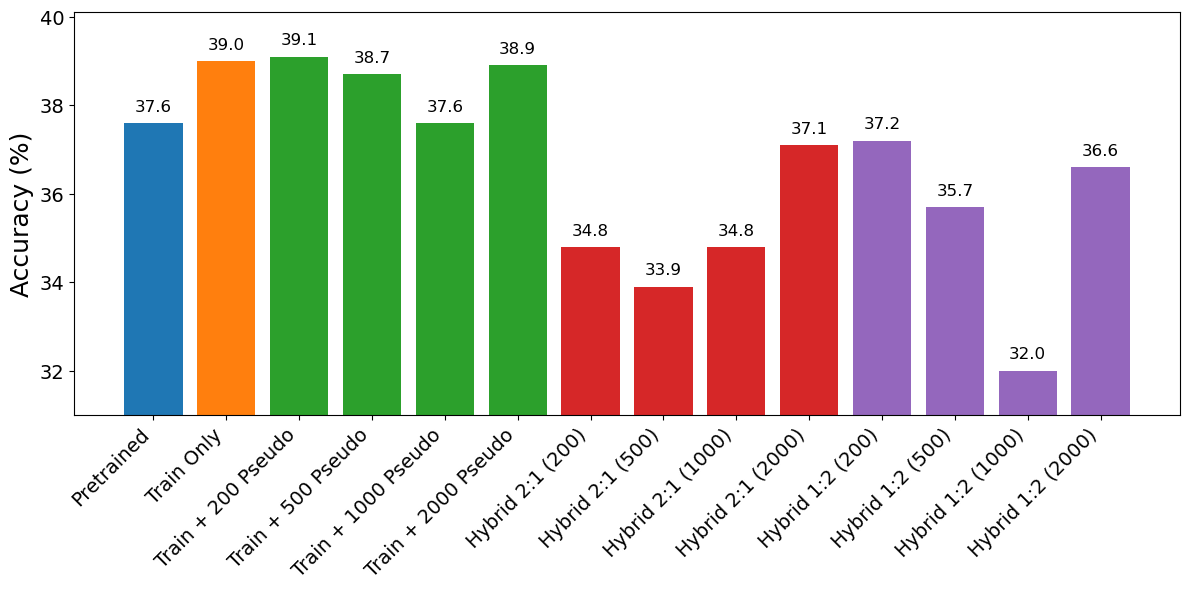

In [18]:
# plot
import matplotlib.pyplot as plt

# Experiment names and corresponding accuracies
labels = [
    "Pretrained",
    "Train Only",
    "Train + 200 Pseudo",
    "Train + 500 Pseudo",
    "Train + 1000 Pseudo",
    "Train + 2000 Pseudo",
    "Hybrid 2:1 (200)",
    "Hybrid 2:1 (500)",
    "Hybrid 2:1 (1000)",
    "Hybrid 2:1 (2000)",
    "Hybrid 1:2 (200)",
    "Hybrid 1:2 (500)",
    "Hybrid 1:2 (1000)",
    "Hybrid 1:2 (2000)"
]
scores = [37.6, 39.0, 39.1, 38.7, 37.6, 38.9, 34.8, 33.9, 34.8, 37.1, 37.2, 35.7, 32.0, 36.6]

# Assign colors based on experiment setting groups
colors_map = {
    "Baseline": "tab:blue",
    "Supervised": "tab:orange",
    "Mixed": "tab:green",
    "Hybrid 2:1": "tab:red",
    "Hybrid 1:2": "tab:purple"
}

colors = []
for label in labels:
    if label in ["Pretrained"]:
        colors.append(colors_map["Baseline"])
    elif label in ["Train Only"]:
        colors.append(colors_map["Supervised"])
    elif "Train +" in label:
        colors.append(colors_map["Mixed"])
    elif "Hybrid 2:1" in label:
        colors.append(colors_map["Hybrid 2:1"])
    elif "Hybrid 1:2" in label:
        colors.append(colors_map["Hybrid 1:2"])
    else:
        colors.append("grey")

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, scores, color=colors)

# Set axis limits and ticks
plt.ylim(min(scores) - 1, max(scores) + 1)
plt.xticks(rotation=45, ha='right', fontsize=14)  # x-axis tick labels
plt.yticks(fontsize=14)                           # y-axis tick labels

# Set axis labels and title with font size
plt.ylabel('Accuracy (%)', fontsize=18)
# plt.title('LLaVA-v1.5-7b Fine-Tuning Results on Evaluation Set', fontsize=14)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.2, f'{height:.1f}',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()

# Save as PDF
plt.savefig("llava_finetuning_results.pdf")
plt.show()
